# **Twitter Sentiment Classifier** 👍👎
*using* **Feed-Forward Neural Networks** *and the* **TF-IDF** *feature generation scheme.*

Let's import some essential libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
import string
import re
from textblob import TextBlob

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **Load the dataset** 🗂

We have to mount (connect) Google Drive where I keep the dataset.

Then, we can import the data in csv format using the pandas `read_csv` method.  
I load 0.65M out of ~1M data from the `SentimentTweets.csv` dataset because more data result to memory crash on colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/SentimentTweets.csv'
data_csv = pd.read_csv(DATA_PATH, nrows=650000)
data_csv = data_csv.dropna()
data_csv.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


## **Data pre-processing** 💽

Converting the csv file data into Pandas DataFrame data structure.

In [ ]:
# Convert the data (from csv type) into dataframe data structure
df = pd.DataFrame(data=data_csv) 
df.head(10)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...
5,725609,0,2262367427,Sat Jun 20 22:22:34 PDT 2009,NO_QUERY,farmtrain,Woot truck fixed!!! Now workin http://myloc.m...
6,1361765,4,2049183514,Fri Jun 05 16:26:26 PDT 2009,NO_QUERY,tinadallasfla,@BLAQSHEEPCEO yea I melt at that lol
7,114606,0,1826379900,Sun May 17 08:22:16 PDT 2009,NO_QUERY,Isoebelle,wants to do something radical...but not sure w...
8,620064,0,2228196366,Thu Jun 18 14:08:18 PDT 2009,NO_QUERY,alox,"@brlamb scratch that, @bgilgoff tweeted it. Ch..."
9,564150,0,2206118765,Wed Jun 17 06:02:05 PDT 2009,NO_QUERY,asimpleparadox,I am sore everywhere. Also found out an assess...


As we can see from above, the target column has 0s and 4s denoting the negative and the positive class respectively. We are going to change the *4s into 1s* using the `replace` method, hence we 'll have:

0 $\rightarrow$ negative tweet 👎

1 $\rightarrow$ positive tweet 👍

In [ ]:
df['target'] = df['target'].replace(4,1)
df.head(10)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,1,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,1,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,1,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...
5,725609,0,2262367427,Sat Jun 20 22:22:34 PDT 2009,NO_QUERY,farmtrain,Woot truck fixed!!! Now workin http://myloc.m...
6,1361765,1,2049183514,Fri Jun 05 16:26:26 PDT 2009,NO_QUERY,tinadallasfla,@BLAQSHEEPCEO yea I melt at that lol
7,114606,0,1826379900,Sun May 17 08:22:16 PDT 2009,NO_QUERY,Isoebelle,wants to do something radical...but not sure w...
8,620064,0,2228196366,Thu Jun 18 14:08:18 PDT 2009,NO_QUERY,alox,"@brlamb scratch that, @bgilgoff tweeted it. Ch..."
9,564150,0,2206118765,Wed Jun 17 06:02:05 PDT 2009,NO_QUERY,asimpleparadox,I am sore everywhere. Also found out an assess...


### **Data cleaning** 🧹

We are going to classify tweets. As we all know, twitter users use the symbols # and @ a lot. This may cause problem to the classifier, thus we are going to remove them. We are also going to lemmatize the data in order to avoid multiple representations of the same word.

In the following code snippet we "clean" the data by doing the following:

* **Drop the uneseccary columns** such as "Unnamed: 0", "id", etc
* **Lower** the characers using the string method `lower` 
* **Remove special characters** such as punctuation points, links, weird characters, etc.

In [ ]:
# Drop unescessary columns
df.drop(columns = ['Unnamed: 0', 'id', 'date', 'flag', 'user'], inplace = True)
df.head()

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


In [ ]:
# Define the function for text cleaning
def text_cleaning(text):
  # Lower characters
  text = text.lower()
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  # Remove non alphanumeric characters
  text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  #StopWords = stopwords.words("english")
  #text = ' '.join([word for word in text.split() if word not in StopWords])
  return text

df['text']=df['text'].apply(text_cleaning)
df.head(10)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...
5,0,woot truck fixed now workin
6,1,blaqsheepceo yea i melt at that lol
7,0,wants to do something radical but not sure wha...
8,0,brlamb scratch that bgilgoff tweeted it chann...
9,0,i am sore everywhere also found out an assessm...


### **Tokenization and Lemmatization** 🔑

**Tokenization** is necessary to prepare the data in order to vectorize them using the TF-IDF scheme.  
The goal of **Lemmatization** (or Stemming) is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.  
For instance, Lemmatization or Stemming will do the following:   
am, are, is $\Rightarrow$ be  
car, cars, car's, cars' $\Rightarrow$ car



In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function that lemmatizes the tokenized text
# text is being tokenized and passed immidiately into the lemmatizer 
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(text)])

df['text'] = df.text.apply(lemmatize_text).copy()

df.head(10)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,complete race 4 life in 58mins with girlies fr...
5,0,woot truck fix now workin
6,1,blaqsheepceo yea i melt at that lol
7,0,want to do something radical but not sure what...
8,0,brlamb scratch that bgilgoff tweet it channel ...
9,0,i be sore everywhere also find out an assessme...


### **Split the dataset** 🖇
into *training, validation* and *testing* sets.

In [ ]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(df, columns = ['text'])
Y = pd.DataFrame(df, columns = ['target'])

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.05, random_state=123)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.05, random_state=123)

In [ ]:
print(trainX.head())

                                                     text
252794  and they be back within hear distance with win...
591124  3 majorettes show tomorrow fuck me i m gonna b...
4804                      choebe guess what i m dling now
230626  i break my hello kitty mobile charm it be one ...
81794   just get do watch some buffy hurray it s bryan...


### **Vectorization with TF-IDF** 🔢
Now, we need to ***convert the text into numbers using the TF-IDF scheme of BoW approach.*** 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get the tweets as a list for each train, val and test datasets
train = trainX['text'].tolist()
val = valX['text'].to_list()
test = testX['text'].tolist()

# stopwords: words that do not provide any useful information,
# i.e. “a”, “the”, “is”, “are” and etc
# STOPWORDS = set(stopwords.words('english'))

# Vectorize with 1100 features
tfidf_vectorizer = TfidfVectorizer(max_features=1100, dtype=np.float32)

tfidf_trainX = tfidf_vectorizer.fit_transform(train)
tfidf_trainX = tfidf_trainX.toarray()

tfidf_valX = tfidf_vectorizer.transform(val)
tfidf_valX = tfidf_valX.toarray()

tfidf_testX = tfidf_vectorizer.transform(test)
tfidf_testX = tfidf_testX.toarray()

print("TF-IDF train shape:", tfidf_trainX.shape)
print("TF-IDF val shape:", tfidf_valX.shape)
print("TF-IDF test shape:", tfidf_testX.shape)

TF-IDF train shape: (586625, 1100)
TF-IDF val shape: (30875, 1100)
TF-IDF test shape: (32500, 1100)


**Convert the X and Y sets into torch *tensors*.**

In [ ]:
# Convert X datasets to tensors.
tfidf_trainX = torch.tensor(tfidf_trainX)
tfidf_valX = torch.tensor(tfidf_valX)
tfidf_testX = torch.tensor(tfidf_testX)

# Convert Y datasets to tensors with torch.squeeze.
trainY = torch.squeeze(torch.from_numpy(trainY.to_numpy()).float())
valY = torch.squeeze(torch.from_numpy(valY.to_numpy()).float())
testY = torch.squeeze(torch.from_numpy(testY.to_numpy()).float())


In [ ]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## **Feed-Forward Neural Network** 🧠

I chose a structure of *four hidden layers*, hence *five functions* in total with each one having the ReLU activation function, plus the sigmoid activation function at the output.

The *structure* of the network is as follows:

Input $\rightarrow$  
  Linear Layer $\rightarrow$ ReLU  
  Linear Layer $\rightarrow$ ReLU   
  Linear Layer $\rightarrow$ ReLU  
  Linear Layer $\rightarrow$ ReLU    
  Linear Layer $\rightarrow$ Sigmoid  
$\rightarrow$ Output

### **Building the network** 🔨

In [ ]:
class FeedForwardNeuralNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim):
    super(FeedForwardNeuralNetwork, self).__init__()

    self.f_1 = nn.Linear(input_dim, hidden_dim_1)
    self.relu_1 = nn.ReLU()

    self.f_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
    self.relu_2 = nn.ReLU()

    self.f_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
    self.relu_3 = nn.ReLU()

    self.f_4 = nn.Linear(hidden_dim_3, hidden_dim_4)
    self.relu_4 = nn.ReLU()

    self.f_5 = nn.Linear(hidden_dim_4, output_dim)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #print(f'x shape: {x.shape}')
    out = self.f_1(x)
    out = self.relu_1(out)
    out = self.f_2(out)
    out = self.relu_2(out)
    out = self.f_3(out)
    out = self.relu_3(out)
    out = self.f_4(out)
    out = self.relu_4(out)
    out = self.f_5(out)
    out = self.sigmoid(out)
    return out

# Initializing the model's parameters
input_dim = tfidf_trainX.shape[1]
#print(f'Input dimension: {input_dim}')
hidden_dim_1 = 300
hidden_dim_2 = 200
hidden_dim_3 = 100
hidden_dim_4 = 20

output_dim = 1

n_epochs = 70

# Define the model in the nn_model variable
nn_model = FeedForwardNeuralNetwork(input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim)
loss_function = nn.BCELoss() # the loss function: Binary Cross Entropy Loss
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-3)

# Send the computation to the selected device (cpu/gpu)
nn_model.to(device)
loss_function.to(device)

BCELoss()

**Split the datasets** into mini-batches in order to use mini-batch Gradient Descent for learning.

**Lower batch-size $\rightarrow$** less data processed on each iteration which means there might be some noise on data and though a less accurate computation by GD.

**Higher batch-size $\rightarrow$** more data processed on each iteration and though a more accurate computation by GD.

In [ ]:
batch_size = 16384 # 2^14

trainX_batches = torch.split(tfidf_trainX, batch_size)
trainY_batches = torch.split(trainY, batch_size)

In [ ]:
def calculate_accuracy(y_prediction, y_true):
  y_prediction = torch.round(y_prediction)
  correct = (y_true == y_prediction).float()
  accuracy = correct.sum() / len(correct)
  return accuracy

**Graphs**

A function for plotting the data got from training phase in order to produce some useful graphs for the model.

In [ ]:
plt.style.use('seaborn-whitegrid') # plot style

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

  ax1.plot(range(epochs), train_loss, 'bo-' , label = 'Training loss')
  ax1.plot(range(epochs), val_loss , 'ro-', label = 'Validation loss')
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Loss/Epoch', y = 1.03, fontsize = 15)
  ax1.set_xlim([-1,epochs])
  ax1.legend(loc="best")
  
  ax2.plot(range(epochs), train_acc, 'bo-' , label = 'Training accuracy')
  ax2.plot(range(epochs), val_acc , 'ro-', label = 'Validation accuracy')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Accuracy/Epoch', y = 1.03, fontsize = 15)
  ax2.set_xlim([-1,epochs])
  ax2.legend(loc="best")

  plt.show()

### **Training** 🏋️‍♂️

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(n_epochs):
  epoch_loss = epoch_accuracy = 0
  val_loss = val_accuracy = 0

  for trainX_mini_batch, trainY_mini_batch in zip(trainX_batches, trainY_batches):
    trainX_mini_batch = trainX_mini_batch.to(device)
    trainY_mini_batch = trainY_mini_batch.to(device)
    #print(f'Train mini-batch shape: {trainX_mini_batch.shape}')
    # Forward pass to get prediction
    train_prediction = nn_model.forward(trainX_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)
    #print(f'Train mini-batch shape: {train_prediction.shape}')

    # Calculate loss
    train_loss = loss_function(train_prediction, trainY_mini_batch)

    # Clearing up accumulated gradients 
    optimizer.zero_grad()

    # Get the gradients using backpropagation power!!
    train_loss.backward()

    # Update parameters, or "learn" :)
    optimizer.step()

    epoch_loss += train_loss.item()
    epoch_accuracy += calculate_accuracy(train_prediction, trainY_mini_batch)
  
  # For each epoch print loss and accucary on train and validation sets.
  tfidf_valX = tfidf_valX.to(device)
  valY = valY.to(device)

  # Forward pass to get output
  val_prediction = nn_model.forward(tfidf_valX.float())
  val_prediction = torch.squeeze(val_prediction)
  
  # Calculate loss
  val_loss = loss_function(val_prediction, valY)

  # Add each mini batch's loss
  validation_loss = val_loss.item()

  # Add each mini batch's accuracy
  val_accuracy = calculate_accuracy(val_prediction, valY)

  epoch_loss /= len(trainX_batches)
  epoch_accuracy /= len(trainX_batches)

  val_losses.append(validation_loss)
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy.cpu())
  val_accuracies.append(val_accuracy.cpu())
  print("Epoch:", epoch, "\n"
          "Train_loss:     \t", round(epoch_loss, 4),      "\tTrain Accuracy:      \t", round(epoch_accuracy.item(), 4), "\n"
          "Validation_loss:\t", round(validation_loss, 4), "\tValidation Accuracy: \t", round(val_accuracy.item(), 4),   "\n")

Epoch: 0 
Train_loss:     	 0.6973 	Train Accuracy:      	 0.5013 
Validation_loss:	 0.6972 	Validation Accuracy: 	 0.4988 

Epoch: 1 
Train_loss:     	 0.6962 	Train Accuracy:      	 0.5013 
Validation_loss:	 0.6961 	Validation Accuracy: 	 0.4988 

Epoch: 2 
Train_loss:     	 0.6952 	Train Accuracy:      	 0.5013 
Validation_loss:	 0.6949 	Validation Accuracy: 	 0.4988 

Epoch: 3 
Train_loss:     	 0.6939 	Train Accuracy:      	 0.5013 
Validation_loss:	 0.6934 	Validation Accuracy: 	 0.4988 

Epoch: 4 
Train_loss:     	 0.6925 	Train Accuracy:      	 0.5013 
Validation_loss:	 0.6915 	Validation Accuracy: 	 0.4988 

Epoch: 5 
Train_loss:     	 0.6898 	Train Accuracy:      	 0.6234 
Validation_loss:	 0.687 	Validation Accuracy: 	 0.6546 

Epoch: 6 
Train_loss:     	 0.6804 	Train Accuracy:      	 0.6475 
Validation_loss:	 0.6688 	Validation Accuracy: 	 0.6805 

Epoch: 7 
Train_loss:     	 0.6477 	Train Accuracy:      	 0.6965 
Validation_loss:	 0.6205 	Validation Accuracy: 	 0.7155 

E

### **Testing** ✅

In [ ]:
tfidf_testX = tfidf_testX.to(device)
testY = testY.to(device)

# Forward pass to get the prediction
test_prediction = nn_model.forward(tfidf_testX.float())
test_prediction = torch.squeeze(test_prediction)

test_accuracy = calculate_accuracy(test_prediction, testY)
print('Model accuracy on test dataset:', round(test_accuracy.item(), 2), "\n")

Model accuracy on test dataset: 0.79 



### **Metrics** 📈

**Classification Report**

In [ ]:
# Get the classification report
from sklearn.metrics import classification_report

test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
testY = testY.cpu()

print(classification_report(testY, test_prediction))

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     16264
         1.0       0.79      0.79      0.79     16236

    accuracy                           0.79     32500
   macro avg       0.79      0.79      0.79     32500
weighted avg       0.79      0.79      0.79     32500



**Plots for *Loss* and *Accuracy* per epoch**

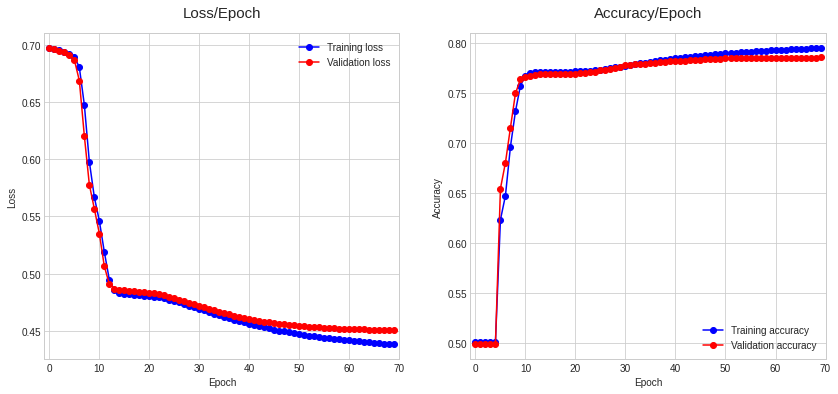

In [ ]:
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, n_epochs)

**ROC curve**

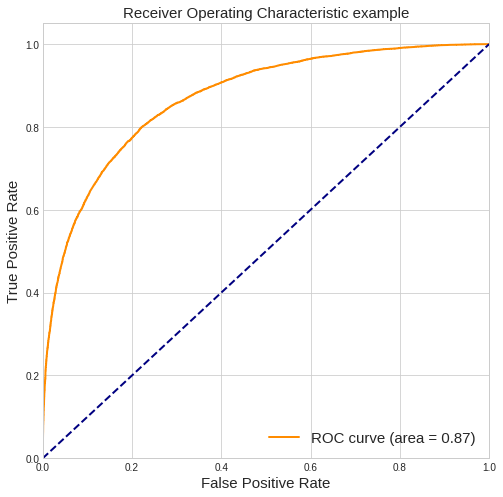

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report

# get the predictions from the model
y_score = nn_model.forward(tfidf_testX.float())

# Convert tensors to numpy arrays after we pass them to cpu.
y_score = y_score.cpu().detach().numpy()
y = testY.cpu().detach().numpy()

# Label binarization and store num of classes.
y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic example', fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()


**Confusion Matrix**

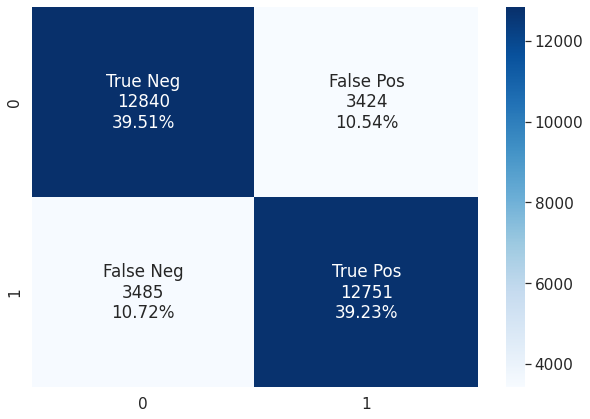

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

df_cf_matrix = pd.DataFrame(confusion_matrix(testY,y_score.round()))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)

group_labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in df_cf_matrix.values.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in df_cf_matrix.values.flatten()/np.sum(df_cf_matrix.values.flatten())]

box_labels = [f"{v1}\n{v2}\n{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(df_cf_matrix.shape[0],df_cf_matrix.shape[1])

sn.heatmap(df_cf_matrix, annot=box_labels, fmt='', cmap='Blues')

## **Summary** (some numbers) 📊

I have built a Feed-Forward Neural Network model which uses the TF-IDF scheme to vectorizing the data (i.e., convert the words into numbers). 

My model got accuracy of ***79%*** and was having the following properties:

- Batch-size = $2^{14}$ = 16384
- Number of epochs = 70
- 4 hidden layers of size 300, 200, 100, 20 respectively
- ReLU activation function for each layer
- Sigmoid function at the output

*I am using the **early stopping** technique at epoch 60 because as can be seen from the plots above, the model starts to **overtfit** the data around the epoch 60.*